# Построение доверительной оценки. Базовая математическая статистика для Data scientist

Задачи:
- Построить доверительный интервал для цен акций из yahoo finance;
- Выделить аномалии;
- Сделать выводы по наличию или отсутствию аномальных событий.

**Источник данных - yahoo finance**
**Проведение анализа реальных котировок (цен финансовых инструментов) настоящих акций Google на бирже.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import sys
import subprocess
from scipy.stats import kurtosis, skew, norm

**Установка yfinance**

In [2]:
import yfinance as yf

In [3]:
# Настройки вывода
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set(style="whitegrid")

Мы будем проводить анализ из сервиса yahoo finance.

Загрузим котировки за интересующий период - 2018 - 2019 годы

In [4]:
start_date = '2020-01-01'
end_date = '2023-10-31'

In [5]:
df = yf.download("GOOG", start=start_date, end=end_date)

if df.empty:
    raise ValueError("Не удалось загрузить данные. Проверьте подключение к интернету или тикер.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 964 entries, 2020-01-02 to 2023-10-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, GOOG)   964 non-null    float64
 1   (High, GOOG)    964 non-null    float64
 2   (Low, GOOG)     964 non-null    float64
 3   (Open, GOOG)    964 non-null    float64
 4   (Volume, GOOG)  964 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 45.2 KB


Переведем заголовки столбцов в нижний регистр и посмотрим на данные

In [10]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2020-01-02,68.046196,68.084512,66.761282,66.761282,28132000
2020-01-03,67.712273,68.301485,66.960037,67.075290,23728000
2020-01-06,69.381882,69.495836,67.181800,67.181800,34646000
2020-01-07,69.338577,69.818801,69.191272,69.567496,30054000
2020-01-08,69.885002,70.246290,69.214176,69.275880,30560000


Для изучения выберем разницу между ценой открытия и ценой закрытия и создадим такую метрику (добавим столбец ВЫРУЧКА в таблицу данных).

In [11]:
df['diff_price'] = df['Close'] - df['Open']

Для построения доверительного интервала необходимо, чтобы исследуемая величина имела распределение по закону Гаусса. Напишем функцию.

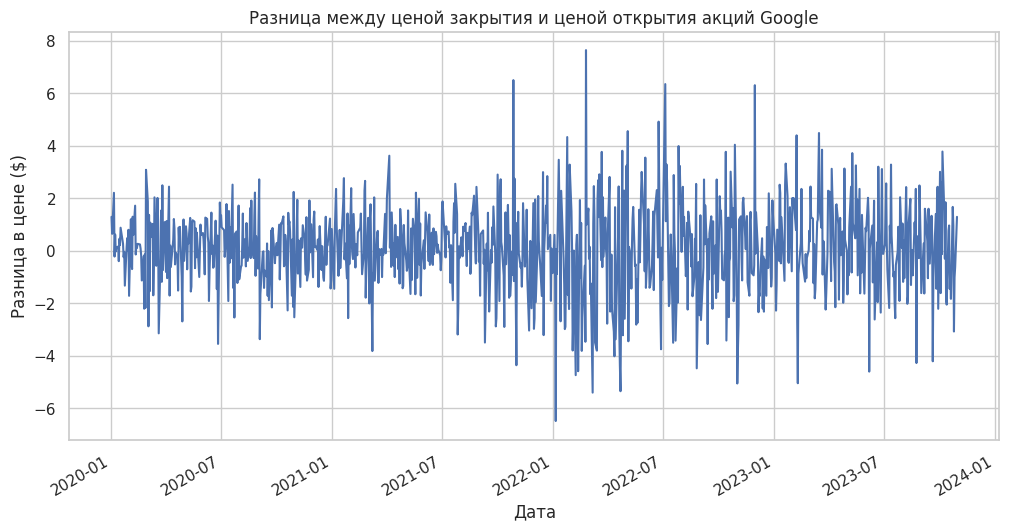

In [12]:
df['diff_price'].plot()
plt.title('Разница между ценой закрытия и ценой открытия акций Google')
plt.xlabel('Дата')
plt.ylabel('Разница в цене ($)')
plt.show()

In [13]:
def my_basic_research(df, column='diff_price'):
    print('📊 Базовые метрики:')
    print(df[column].describe())
    print('\n🔝 Топ-5 самых популярных значений:')
    print(df[column].value_counts().nlargest(5))
    print('\n📈 Эксцесс:', kurtosis(df[column]))
    print('📉 Асимметрия:', skew(df[column]))

    sns.histplot(df[column], kde=True, bins=50, color='skyblue')
    plt.title('Распределение разницы цен')
    plt.xlabel('Разница ($)')
    plt.ylabel('Частота')
    plt.show()

📊 Базовые метрики:
count    964.000000
mean       0.083679
std        1.670541
min       -6.496725
25%       -0.888036
50%        0.143444
75%        1.107257
max        7.637318
Name: diff_price, dtype: float64

🔝 Топ-5 самых популярных значений:
diff_price
1.283920    1
1.284914    1
0.636982    1
2.200082    1
3.772127    1
Name: count, dtype: int64

📈 Эксцесс: 1.3002215713098968
📉 Асимметрия: -0.07889295865519047


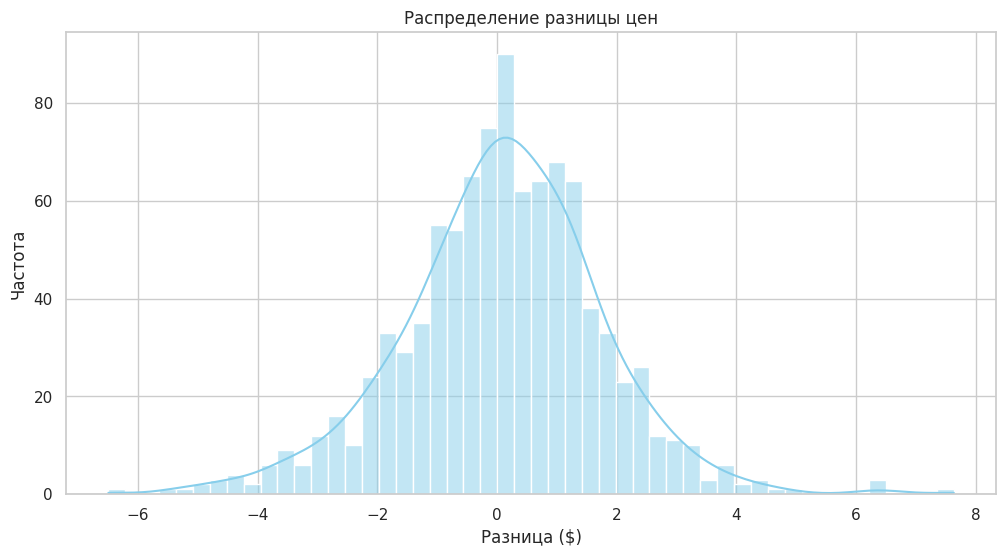

In [14]:
my_basic_research(df, column='diff_price')

Наше распределение близко к нормальному, несмотря на остроконечный пик и наличие выбросов.

Проверим данные при помощи графика QQ plot. Этот график сравнивает квантили выборки и выбранного распределения - в нашем случае нормального распределения. Если графики располагаются под 45 градусов, то всё хорошо и данные распределены по нормальным законам.

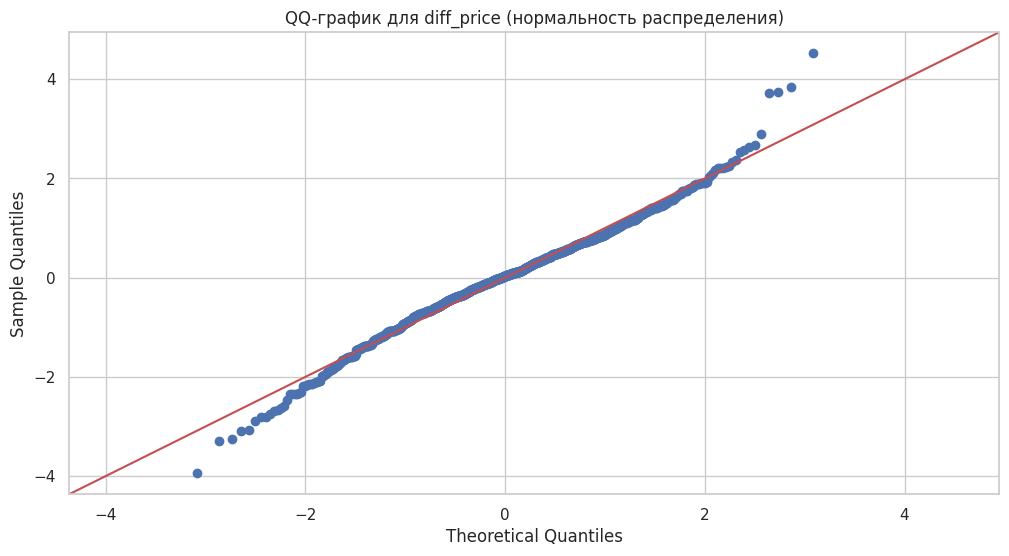

In [15]:
# QQ-график
sm.qqplot(df['diff_price'], fit=True, line='45')
plt.title("QQ-график для diff_price (нормальность распределения)")
plt.show()

Наши данные близки к нормальному распределению. Можно использовать стандартные доверительные интервалы для нормального распределения. Построим функцию (http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).

In [16]:
def my_norm_confidence(df, column='diff_price', alpha=0.95):
    mean = df[column].mean()
    std = df[column].std()
    interval = norm.interval(alpha, loc=mean, scale=std)
    return interval

In [17]:
confidence_95 = my_norm_confidence(df)
confidence_90 = my_norm_confidence(df, alpha=0.90)

print(f"95% доверительный интервал: {confidence_95}")
print(f"90% доверительный интервал: {confidence_90}")

95% доверительный интервал: (np.float64(-3.190521504933402), np.float64(3.3578797755819343))
90% доверительный интервал: (np.float64(-2.664116661422733), np.float64(2.8314749320712638))


При доверительной вероятности 95% средняя разница между ценой закрытия и ценой открытия не выйдет за этот интервал - от минус 3.1 до плюс 3.3 доллара. Отметим на графике полученный коридор. Красная граница будет нижний уровень доверительного интервала, а зеленая линия - верхняя.

In [20]:
# Вычисляем доверительный интервал
confidence = my_norm_confidence(df, column='diff_price', alpha=0.95)

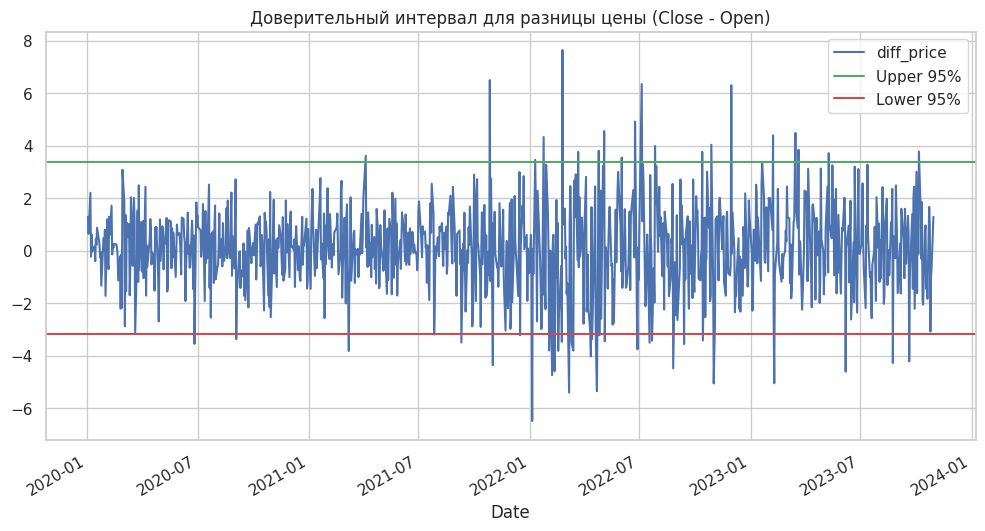

In [21]:
# Строим график с доверительными границами
df['diff_price'].plot()
plt.axhline(y=confidence[1], color='g', linestyle='-', label='Upper 95%')
plt.axhline(y=confidence[0], color='r', linestyle='-', label='Lower 95%')
plt.title('Доверительный интервал для разницы цены (Close - Open)')
plt.legend()
plt.show()

# Отбор аномалий при помощи доверительного интервала

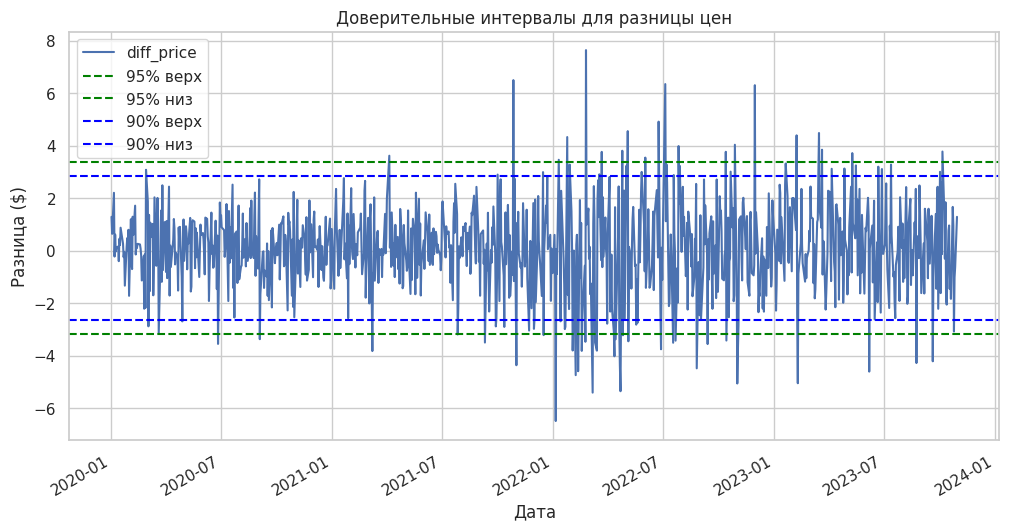

In [22]:
# Визуализация интервалов
df['diff_price'].plot()
plt.axhline(y=confidence_95[1], color='green', linestyle='--', label='95% верх')
plt.axhline(y=confidence_95[0], color='green', linestyle='--', label='95% низ')

plt.axhline(y=confidence_90[1], color='blue', linestyle='--', label='90% верх')
plt.axhline(y=confidence_90[0], color='blue', linestyle='--', label='90% низ')

plt.title('Доверительные интервалы для разницы цен')
plt.xlabel('Дата')
plt.ylabel('Разница ($)')
plt.legend()
plt.show()

Отметим аномальные события, выходящие за зеленую границу.

In [23]:
# Выделение аномалий
df['anomaly_95'] = ((df['diff_price'] > confidence_95[1]) | (df['diff_price'] < confidence_95[0])).astype(int)
df['anomaly_90'] = ((df['diff_price'] > confidence_90[1]) | (df['diff_price'] < confidence_90[0])).astype(int)

print("\nАномалии по 95% интервалу:")
print(df[df['anomaly_95'] == 1][['Open', 'Close', 'diff_price']].describe())

print("\nАномалии по 90% интервалу:")
print(df[df['anomaly_90'] == 1][['Open', 'Close', 'diff_price']].describe())


Аномалии по 95% интервалу:
Price         Open       Close diff_price
Ticker        GOOG        GOOG           
count    54.000000   54.000000  54.000000
mean    119.494623  118.621468  -0.873155
std      18.400701   17.790235   4.290306
min      71.232112   67.674461  -6.496725
25%     107.040634  107.610308  -3.979896
50%     120.912556  120.523647  -3.445678
75%     134.250882  131.957222   3.769640
max     151.147578  147.338623   7.637318

Аномалии по 90% интервалу:
Price         Open       Close diff_price
Ticker        GOOG        GOOG           
count    93.000000   93.000000  93.000000
mean    118.102747  117.732365  -0.370383
std      20.901540   20.545554   3.841255
min      56.518301   53.363247  -6.496725
25%     105.271378  107.849174  -3.507389
50%     119.653766  120.509209  -2.823131
75%     134.091894  133.497696   3.273998
max     151.147578  147.338623   7.637318


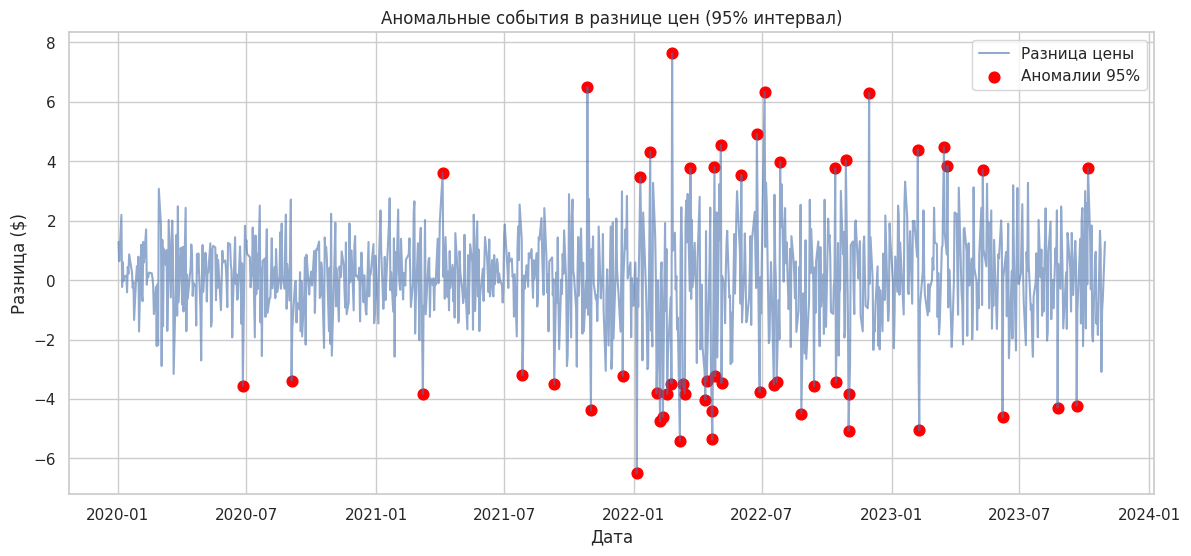

In [24]:
# Визуализация аномалий
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['diff_price'], label='Разница цены', alpha=0.6)
plt.scatter(df[df['anomaly_95'] == 1].index, df[df['anomaly_95'] == 1]['diff_price'],
            color='red', label='Аномалии 95%', s=60)
plt.title("Аномальные события в разнице цен (95% интервал)")
plt.xlabel('Дата')
plt.ylabel('Разница ($)')
plt.legend()
plt.show()